<a href="https://colab.research.google.com/github/MdEmonMiaOfficial/ML-Th-Lab/blob/main/Real_Estate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === P1: Imports & Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

RANDOM_STATE = 42
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [2]:
# === Load dataset ===
df = pd.read_csv("/Real_estate - Real_estate.csv")   # Adjust path if needed

print("Shape:", df.shape)
display(df.head())
display(df.describe())


Shape: (414, 7)


,Trans date,House age,Distance station,No of stores,Latitude,Longitude,House Price
0,"2,012.92",32.00,84.88,10,24.98,121.54,37.90
1,"2,012.92",19.50,306.59,9,24.98,121.54,42.20
2,"2,013.58",13.30,561.98,5,24.99,121.54,47.30
3,"2,013.50",13.30,561.98,5,24.99,121.54,54.80
4,"2,012.83",5.00,390.57,5,24.98,121.54,43.10


,Trans date,House age,Distance station,No of stores,Latitude,Longitude,House Price
count,414.00,414.00,414.00,414.00,414.00,414.00,414.00
mean,"2,013.15",17.71,"1,083.89",4.09,24.97,121.53,37.98
std,0.28,11.39,"1,262.11",2.95,0.01,0.02,13.61
min,"2,012.67",0.00,23.38,0.00,24.93,121.47,7.60
25%,"2,012.92",9.03,289.32,1.00,24.96,121.53,27.70
50%,"2,013.17",16.10,492.23,4.00,24.97,121.54,38.45
75%,"2,013.42",28.15,"1,454.28",6.00,24.98,121.54,46.60
max,"2,013.58",43.80,"6,488.02",10.00,25.01,121.57,117.50


In [16]:
# Handle missing values (median fill)
# Based on the available columns, I'll handle missing values for relevant columns.
for col in ['House age','Distance station','No of stores','House Price','Latitude','Longitude']:
    if col in df.columns: # Check if column exists before filling
        df[col] = df[col].fillna(df[col].median())

# Handle outliers using IQR capping
def winsorize(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series.clip(lower, upper)

# Apply winsorization to relevant columns
for col in ['House age','Distance station','No of stores','House Price']:
    if col in df.columns: # Check if column exists before winsorizing
        df[col] = winsorize(df[col])

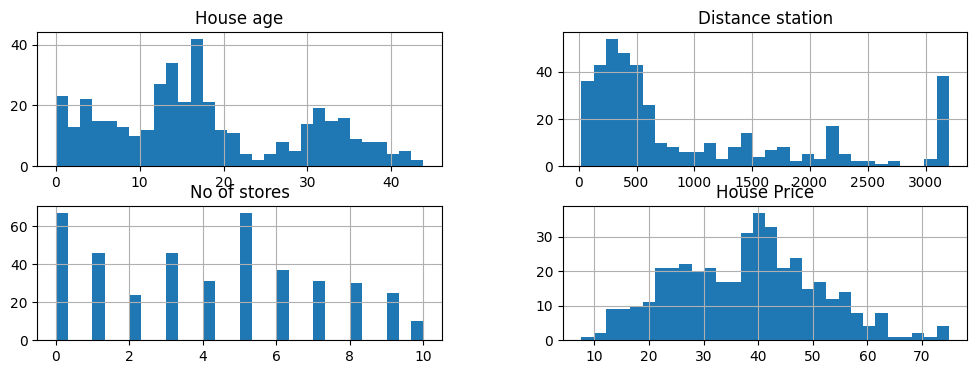

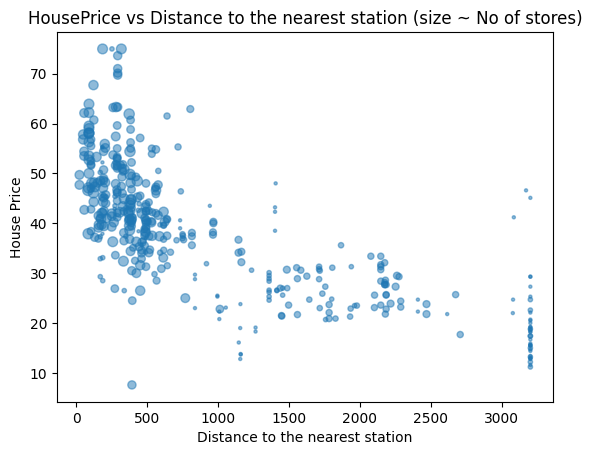

                  House age  Distance station  No of stores  House Price
House age              1.00             -0.00          0.05        -0.22
Distance station      -0.00              1.00         -0.64        -0.72
No of stores           0.05             -0.64          1.00         0.60
House Price           -0.22             -0.72          0.60         1.00


In [17]:
# Histograms
df[['House age','Distance station','No of stores','House Price']].hist(bins=30, figsize=(12,4))
plt.show()

# Scatter relationship
plt.scatter(df['Distance station'], df['House Price'],
            s=(df['No of stores']+1)*5, alpha=0.5)
plt.xlabel("Distance to the nearest station")
plt.ylabel("House Price")
plt.title("HousePrice vs Distance to the nearest station (size ~ No of stores)")
plt.show()

# Correlation matrix
print(df[['House age','Distance station','No of stores','House Price']].corr())

In [ ]:
#P2: Linear Regression

In [19]:
X = df[['House age','Distance station', 'No of stores', 'Latitude', 'Longitude']]
y = df['House Price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)

# Build model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

MAE: 4.810416452980473
Intercept: -2711.250371091099
Coefficients: {'House age': np.float64(-0.2791400528378171), 'Distance station': np.float64(-0.006416974474664272), 'No of stores': np.float64(0.9621319380149213), 'Latitude': np.float64(223.13396818080204), 'Longitude': np.float64(-23.16218008551493)}


In [ ]:
#P4: K-Means Clustering

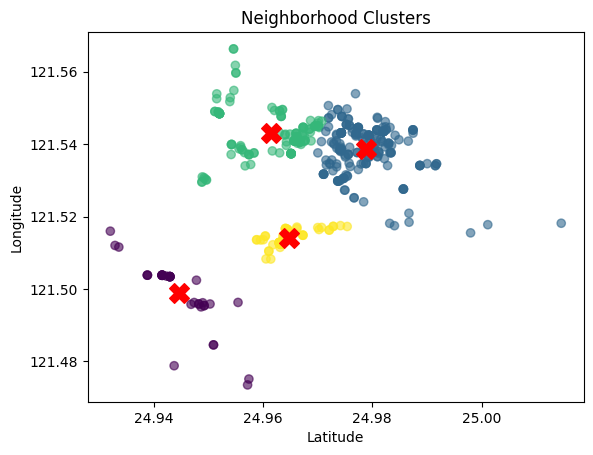

,Count,AvgPrice,LatCenter,LongCenter
Cluster,,,,
0,36,18.46,24.94,121.50
1,206,44.91,24.98,121.54
2,120,36.57,24.96,121.54
3,52,26.36,24.96,121.51


In [21]:
geo = df[['Latitude','Longitude']]

# Scale
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
df['Cluster'] = kmeans.fit_predict(geo_scaled)

# Plot clusters
plt.scatter(df['Latitude'], df['Longitude'], c=df['Cluster'], alpha=0.6)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='X', s=200)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Neighborhood Clusters")
plt.show()

# Summary
cluster_summary = df.groupby('Cluster').agg(
    Count=('Cluster','size'),
    AvgPrice=('House Price','mean'),
    LatCenter=('Latitude','mean'),
    LongCenter=('Longitude','mean')
)
display(cluster_summary)